In [1]:
# Import required modules
import torch
import numpy as np
import sde_lib
import matplotlib.pyplot as plt
from vector_fields.vector_utils import  calculate_centers,curl
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from lightning_data_modules.SyntheticTimeSeries import SyntheticTimeSeriesDataModule
from lightning_data_modules.CryptoDataset import CryptoDataModule
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from lightning_modules.ConservativeSdeGenerativeModel import ConservativeSdeGenerativeModel
from lightning_modules.ConditionalSdeGenerativeModel import ConditionalSdeGenerativeModel
from models.csdi import CSDI
from models.utils import get_score_fn
from models import utils as mutils
from sampling.unconditional import get_sampling_fn
from sampling.conditional import get_conditional_sampling_fn

In [2]:
from configs.jan.crypto.default import get_config
config = get_config()

model.sigma_max: 1.0000


In [3]:
data_m = CryptoDataModule(config)
data_m.setup(stage=None)
time_series_data = data_m

In [4]:
ckpt_path = 'logs/crypto/btc_d_returns/checkpoints/best/last.ckpt'
model = ConditionalSdeGenerativeModel.load_from_checkpoint(ckpt_path)
score_model = model.score_model

In [5]:
num_samples = 1          
sde = sde_lib.cVESDE(sigma_min=config.model.sigma_min_x, sigma_max=config.model.sigma_max_x, N=config.model.num_scales, data_mean=None)
sampling_eps = 1e-5
sampling_shape = [num_samples] +  config.data.shape

sampling_eps = 1e-3
conditional_sampling_fn = get_conditional_sampling_fn(config=config, sde=sde, 
                                                        shape=sampling_shape, eps=sampling_eps,
                                                        use_path=False)


In [6]:
test_data_loader = data_m.test_dataloader()


In [7]:
y, x = iter(test_data_loader).next()
y['input'] = y['input'][0].unsqueeze(0)
y['timesteps'] = y['timesteps'][0].unsqueeze(0)
x = x[0].unsqueeze(0)

In [8]:
sample = conditional_sampling_fn(score_model, y=y)[0]

100%|██████████| 50/50 [00:00<00:00, 85.09it/s]


In [25]:
def generate_forecast():
    n=10
    dt=1
    cond_size = 30
    pred_size = 1
    times=y['timesteps'].squeeze(0)[:cond_size]
    forecast=y['input'][0].unsqueeze(0)
    for k in range(n):
        t_past = times[-cond_size:]
        t_next = torch.tensor([times[-1] + (i+1)*dt for i in range(pred_size)])
        times = torch.cat([times, t_next])
        y_next = {'input': forecast[:,-cond_size:,:], 'timesteps':torch.cat([t_past, t_next]).unsqueeze(0) }
        sample = conditional_sampling_fn(score_model, y=y_next)[0]
        forecast = torch.cat([forecast, sample], dim = 1)
    return forecast


In [34]:
fs=[]
for i in range(10):
    fs.append(generate_forecast())

100%|██████████| 50/50 [00:00<00:00, 96.40it/s]


In [35]:
forecast = torch.stack(fs).mean(dim=0)


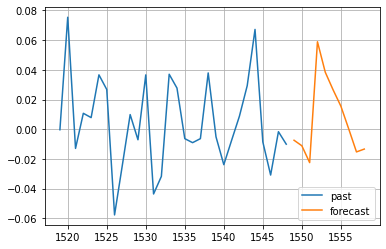

In [36]:
vals=forecast.squeeze()
plt.plot(times[:cond_size], vals[:cond_size], label='past')
plt.plot(times[cond_size:], vals[cond_size:], label='forecast')
plt.legend()
#plt.ylim(0,2)
plt.grid()